**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [657]:
# write your code here
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import time
import copy 
from types import SimpleNamespace

import numpy as np
import sympy as sm

from scipy import linalg
from scipy import optimize
from scipy.optimize import minimize

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
plt.rcParams.update({"axes.grid": True, "grid.color": "black",
                    "grid.alpha": "0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [658]:
# define parameters
mp = SimpleNamespace()

mp.alpha = 0.5
mp.kappa = 1
mp.nu = 1 /(2*16**2)
mp.w = 1.0
mp.tau = 0.3

# define as sympy symbols
alpha = sm.symbols('alpha')
kappa = sm.symbols('kappa')
nu = sm.symbols('nu')

w = sm.symbols('w')
w_tilde = sm.symbols('w_tilde')
tau = sm.symbols('tau')

L = sm.symbols('L')
G = sm.symbols('G')
C = sm.symbols('C')

In [659]:
utility = sm.log(C**alpha * G**(1-alpha)) - nu *(L**2)/2

budget_constraint = sm.Eq(kappa + w_tilde*L,C)
budget_contraint__tilde = sm.Eq(kappa + (1-tau)*w*L,C)
budget_constraint

# isolate L
C_from_con = sm.solve(budget_constraint, C)
C_from_con_tilde = sm.solve(budget_contraint__tilde, C)
C_from_con[0]

L*w_tilde + kappa

In [660]:
objective_subs = utility.subs(C, C_from_con[0])
objective_subs_tilde = utility.subs(C, C_from_con_tilde[0])
objective_subs

-L**2*nu/2 + log(G**(1 - alpha)*(L*w_tilde + kappa)**alpha)

In [661]:
foc = sm.diff(objective_subs, L)
foc_tilde = sm.diff(objective_subs_tilde, L)
foc

G**(1 - alpha)*G**(alpha - 1)*alpha*w_tilde/(L*w_tilde + kappa) - L*nu

In [662]:
sol = sm.solve(sm.Eq(foc,0), L)
sol_tilde = sm.solve(sm.Eq(foc_tilde,0), L)
sol[0]

(-kappa*nu - sqrt(nu*(4*alpha*w_tilde**2 + kappa**2*nu)))/(2*nu*w_tilde)

Were we to move the nu, this would be identical to $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

<lambdifygenerated-51>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1/2)*(kappa*nu - sqrt(nu*(4*alpha*tau**2*w**2 - 8*alpha*tau*w**2 + 4*alpha*w**2 + kappa**2*nu)))/(nu*w*(tau - 1))


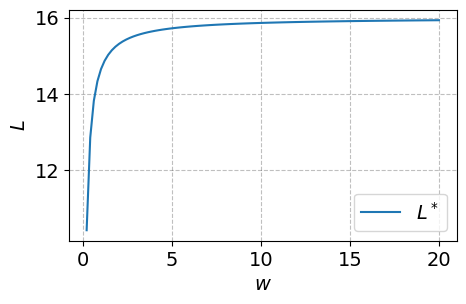

In [663]:
# To run this, push "Run All"

# lambdify the sol[0] function
L_opt = sm.lambdify((alpha, kappa, nu, w, tau), sol_tilde[0])

# define vector of w_tilde
w_vec = np.linspace(0, 10, 100)

# loop over w_tilde_vec and calculate optimal labor supply
L_opt_vec = np.empty_like(w_vec)

for i, w in enumerate(w_vec):
    L_opt_vec[i] = L_opt(mp.alpha, mp.kappa, mp.nu, w, mp.tau)

# plot
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1,1,1)

ax.plot(w_tilde_vec, L_opt_vec, label=r"$L^*$")

ax.set_xlabel(r"${w}$")
ax.set_ylabel(r"$L$")
ax.legend()

plt.show()


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


The consumer optimize its utility function by choosing a number of hours between 0 and 24. 

The utility depends on the amount of government spending, the private consumption and the disutility from work. 

Hence, the consumer takes the structure of the government spending into account when deciding how much to work. 

In [664]:
# define parameters
mp = SimpleNamespace()

mp.alpha = 0.5
mp.kappa = 1
mp.nu = 1/(2*16**2) #= 0.00390625
mp.w = 1.0
mp.tau = 0.3

def objective(l,mp,tau):
    """ objective function
    
    Args:
        l (float): labor
        mp (SimpleNamespace): model parameters
        tau (float): tax rate

    Returns:
        float: objective value
    """

    g = tau*mp.w*l

    c = mp.kappa + (1-tau)*mp.w*l

    # to avoid log(0)
    if c**mp.alpha * g**(1-mp.alpha) <= 0:
        return 1e-8

    utility = np.log(c**mp.alpha * g**(1-mp.alpha))

    disutility = mp.nu * (l**2)/2

    return  utility - disutility

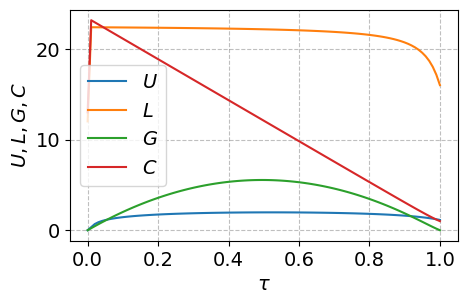

In [665]:
# optimize the objective function using scipy.optimize.minimize
# initial guess
l0 = 12

# bounds
bnds = ((0, 24),)

# definte vector of tau
tau_vec = np.linspace(0, 1, 100)

#initialize vector of L
U_vec = np.empty_like(tau_vec)
L_vec = np.empty_like(tau_vec)
C_vec = np.empty_like(tau_vec)
G_vec = np.empty_like(tau_vec)

# # loop over tau_vec and calculate optimal labor supply
for i, tau in enumerate(tau_vec):
    obj = lambda l: -objective(l, mp, tau)
    # optimize the objective function wrt to L
    result= optimize.minimize(obj,l0,method='L-BFGS-B',bounds=bnds)
    
    U_vec[i] = -result.fun
    L_vec[i] = result.x
    C_vec[i] = mp.kappa + (1-tau)*mp.w*result.x
    G_vec[i] = tau*mp.w*result.x*((1-tau)*mp.w)

# plot the results
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1,1,1)

ax.plot(tau_vec, U_vec, label=r"$U$")
ax.plot(tau_vec, L_vec, label=r"$L$")
ax.plot(tau_vec, G_vec, label=r"$G$")
ax.plot(tau_vec, C_vec, label=r"$C$")
ax.legend()

ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$U, L, G, C$")

plt.show()

According to this plot the worker utility is greatest when $\tau$ is close to 0 or 1.

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

The highest utility is 1.97 and it is achieved at tau = 0.53


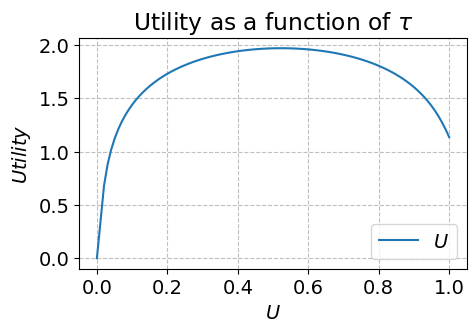

In [666]:
# the tax revenu as a function of tau
tau_vec = np.linspace(0, 1, 100)

# initialize vector of tax revenue
utility_vec = np.empty_like(tau_vec)

# loop over tau_vec and calculate tax revenue
for i, tau in enumerate(tau_vec):
    obj = lambda l: -objective(l, mp, tau)
    # optimize the objective function wrt to L
    result= optimize.minimize(obj, l0, bounds=bnds, method='Nelder-Mead')
    utility_vec[i] = -result.fun

# find the higest value of obj and the corresponding tau
max_utility = np.max(utility_vec)
max_tau = tau_vec[np.argmax(utility_vec)]

print(f"The highest utility is {max_utility:.2f} and it is achieved at tau = {max_tau:.2f}")

# plot the results
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1,1,1)

ax.plot(tau_vec, utility_vec, label=r"$U$")
ax.legend()

ax.set_xlabel(r"$U$")
ax.set_ylabel(r"$Utility$")
ax.set_title(r"Utility as a function of $\tau$")

plt.show()

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [667]:
# define parameters
mp1 = copy.deepcopy(mp)
mp1.sigma = 1.001
mp1.rho = 1.001
mp1.eps = 1.0
mp1.tau = max_tau

mp2 = copy.deepcopy(mp)
mp2.sigma = 1.5
mp2.rho = 1.5
mp2.eps = 1.0
mp2.tau = max_tau

# equation
def utility(l, mp):
    """ utility function
    
    Args:
        l (float): labor
        mp (SimpleNamespace): model parameters

    Returns:
        float: utility value

    """

    g = mp.tau*mp.w*l

    c = mp.kappa + (1-mp.tau)*mp.w*l

    if mp.sigma == 1:
        mp.sigma = 1 + 1e-8

    if mp.rho == 1:
        mp.rho = 1 + 1e-8
        
    numerator = ((mp.alpha*c**((mp.sigma-1)/mp.sigma)+(1-mp.alpha)*g**(((mp.sigma-1)/mp.sigma)))**(1-mp.rho)-1)
    denominator = 1-mp.rho

    return  numerator/denominator

    def disutility(l, mp):
        """ disutility function
        
        Args:
            l (float): labor
            mp (SimpleNamespace): model parameters
    
        Returns:
            float: disutility value
    
        """
        return mp.nu * (l**(1+mp.eps))/(1+mp.eps)

# objective function
def objective_general(l, mp):
    """ objective function
    
    Args:
        l (float): labor
        mp (SimpleNamespace): model parameters
    
    Returns:
        float: objective value
    
    """
    return utility(l, mp) - disutility(l, mp)

In [668]:
# optimize the objective function using scipy.optimize.minimize
# initial guess
l0 = 12

# bounds
bnds = ((0, 24),)

# optimize the objective function wrt to L, and return the optimal G
obj_1 = lambda l: -objective_general(l, mp1)
result1 = optimize.minimize(obj_1, l0, bounds=bnds, method='Nelder-Mead')
L1 = result1.x
G1 = mp1.tau*mp1.w*result1.x
print('the optimal G for set 1 is')
print(G1)
print('the optimal L for set 1 is')
print(L1)
print('------------------------------------------------------------------')
obj_2 = lambda l: -objective_general(l, mp2)
result2 = optimize.minimize(obj_2, l0, bounds=bnds, method='Nelder-Mead')
L2 = result2.x
G2 = mp2.tau*mp2.w*result2.x
print('the optimal G for set 2 is')
print(G2)
print('the optimal L for set 2 is')
print(result2.x)

the optimal G for set 1 is
[0.29199219]
the optimal L for set 1 is
[0.5559082]
------------------------------------------------------------------
the optimal G for set 2 is
[5.66891868]
the optimal L for set 2 is
[10.79274902]


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [669]:
# define list of mp1 and mp2
mp_list = [mp1, mp2]

# define vector of tau 
tau_vec = np.linspace(0, 1, 100)

# initialize vector of utility levels
utility_vec = np.empty_like(tau_vec)

# loop over tau_vec and calculate utility levels
for i, tau in enumerate(tau_vec):
    mp = mp1
    mp.tau = tau
    obj = lambda l: -objective_general(l, mp)
    result= optimize.minimize(obj, l0, bounds=bnds, method='Nelder-Mead')
    utility_vec[i] = -result.fun

# find the higest value of obj and the corresponding tau
max_utility = np.max(utility_vec)
max_tau = tau_vec[np.argmax(utility_vec)]

print(f"Set 1: The highest utility is {max_utility:.10f} and it is achieved at tau = {max_tau:.10f}")
print('------------------------------------------------------------------')

# loop over tau_vec and calculate utility levels
for i, tau in enumerate(tau_vec):
    mp = mp2
    mp.tau = tau
    obj = lambda l: -objective_general(l, mp)
    result= optimize.minimize(obj, l0, bounds=bnds, method='Nelder-Mead')
    utility_vec[i] = -result.fun

# find the higest value of obj and the corresponding tau
max_utility = np.max(utility_vec)
max_tau = tau_vec[np.argmax(utility_vec)]

print(f"Set 2: The highest utility is {max_utility:.10f} and it is achieved at tau = {max_tau:.10f}")

Set 1: The highest utility is -0.0005902461 and it is achieved at tau = 1.0000000000
------------------------------------------------------------------
Set 2: The highest utility is 0.3982596680 and it is achieved at tau = 0.5454545455


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [678]:
## Importing the model and the solution from the py-file. 
%run exam_Q2.py

# Setting the model and printing the results from the numerical maximization  
exercise = Exercise2_1()
exercise.maximize_profit()
exercise.print_results()

For kappa = 1:
Ell: 0.24999994459303015
P: 0.24999999999999695

For kappa = 2:
Ell: 0.9999999144499445
P: 0.9999999999999982



We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [679]:
# Importing the model and the solution from the py-file
%run exam_Q2.py
#from exam_Q2 import Exercise2_2

# Create an instance of Exercise2_2
exercise = Exercise2_2()

# Calculate the ex ante expected value of the salon
H = exercise.calculate_expected_value(exercise.par.eta)

# Print the result
print("Ex ante expected value of the salon (H):", H)

Ex ante expected value of the salon (H): 7.44866065130735


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [680]:
# Importing the model and the solution from the py-file
%run exam_Q2.py

# Create an instance of Exercise2_3
exercise = Exercise2_3()

# Calculate the ex ante expected value of the salon
H = exercise.calculate_expected_value(exercise.par.eta)

# Print the result
print("Ex ante expected value of the salon (H):", H)
print("Yes, it improves profitability when introducing the labor fork")

Ex ante expected value of the salon (H): 7.043074254189291
Yes, it improves profitability when introducing the labor fork


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

Maximum expected value (H): 7.360340504410846
Delta value that maximizes H: 0.01


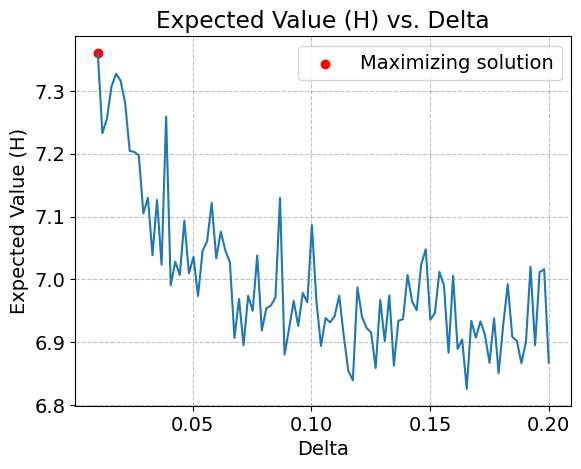

In [681]:
# Create an instance of Exercise2_4
exercise = Exercise2_4()
delta_values = np.linspace(0.01, 0.2, num=100)  # Vary delta from 0.01 to 0.2

# Calculate the maximum expected value, corresponding delta, and H values
max_H, max_delta, H_values = exercise.calculate_expected_value(exercise.par.eta, delta_values)

print(f"Maximum expected value (H): {max_H}")
print(f"Delta value that maximizes H: {max_delta}")

# Plot the results
plt.plot(delta_values, H_values)
plt.xlabel('Delta')
plt.ylabel('Expected Value (H)')
plt.title('Expected Value (H) vs. Delta')

# Highlight the solution
plt.scatter(max_delta, max_H, color='red', label='Maximizing solution')
plt.legend()

plt.show()


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [674]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [675]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [676]:
# write your code here

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [677]:
# write your code here